In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from timeit import default_timer as timer

# Preprocessing

In [2]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [7]:
df

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
0,0.108590,0.004314,-37.566,0.017364,0.289150,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.10,1.01770,1
1,0.100900,0.299610,11822.000,0.276500,0.459700,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.00,0.28359,0
2,0.178030,-0.006980,907.270,0.272140,0.459480,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.20,0.40690,1
3,0.152360,0.007259,780.100,0.025179,0.519470,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.10,0.51486,1
4,0.116230,0.502900,-109.150,0.297910,0.344900,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3228.00,0.23049,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957914,0.098979,0.202530,2192.100,0.348010,0.276430,-0.84065,2214.20,26246.0,1.061600e+15,10882.000,...,-51.2970,1.7323,20.76300,14.74400,27415.00,1.2160,2.139400e+13,2612.00,0.42597,0
957915,0.134930,0.413600,1050.100,0.000521,-0.001246,1.76990,3519.90,862290.0,7.321400e+13,2869.000,...,-41.4180,2.6986,-1.09760,-1.09980,13826.00,1.3320,1.829400e+17,3300.50,0.92974,1
957916,0.104660,0.473510,2415.400,0.252230,0.196970,-0.82323,3044.90,13832.0,2.693300e+12,2294.700,...,-15.9670,1.6843,1.07590,16.64600,8655.10,1.1113,1.925800e+16,297.61,0.91446,0
957917,0.118190,0.320870,657.860,0.237290,0.260250,-0.71237,173.20,20811.0,9.711000e+14,14315.000,...,-2.8375,1.3006,132.50000,8.53050,3842.10,1.1941,1.248300e+16,5212.10,0.20942,1


In [4]:
df = df.drop(columns='id')
df_test = df_test.drop(columns='id')

## Impute missing values

In [5]:
df.isnull().sum()

f1       15247
f2       15190
f3       15491
f4       15560
f5       15405
         ...  
f115     15559
f116     15589
f117     15407
f118     15212
claim        0
Length: 119, dtype: int64

In [6]:
df = df.fillna(df.median())
df_test = df_test.fillna(df.median())

In [8]:
df.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

## Remove outliers

In [9]:
from scipy import stats

z = np.abs(stats.zscore(df))
out = np.where(z>5)
out[0]

array([    21,     73,    125, ..., 957865, 957875, 957894])

In [10]:
df.shape

(957919, 119)

In [11]:
df = df.drop(index=out[0], axis=0)
df.shape

(930360, 119)

## Check balance

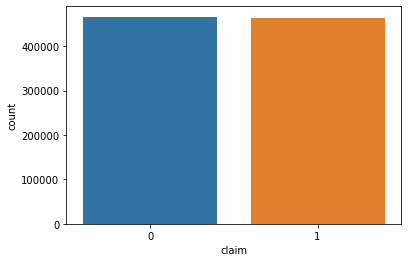

In [12]:
sns.countplot(data=df, x='claim');
# balanced

## Get X,y and split into train and val sets

In [21]:
frac = 0.1
X = df.drop(columns='claim').sample(frac=frac, random_state=42)
y = df['claim'].sample(frac=frac, random_state=42)

X_test = df_test.copy()

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((74428, 118), (18608, 118))

## Feature Selection

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor(n_estimators=10, n_jobs=10) 
rfe = RFE(estimator, n_features_to_select=20)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_val_rfe = rfe.fit_transform(X_val, y_val)

In [ ]:
plt.figure(figsize=(50,5), dpi=100)
sns.barplot(x=X_train.columns, y=max(rfe.ranking_)-rfe.ranking_);

In [ ]:
rfe_features = X_train.columns[rfe.support_]
rfe_features

## ML Models

### Scaling

In [24]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)
X_test = scalar.transform(X_test)

In [25]:
def fit_ML_model(modelName, model, acc=pd.DataFrame([], index=['Train Accuracy','Test Accuracy','Time (s)'])):

    from sklearn.metrics import accuracy_score
    
    start = timer()
    model.fit(X_train, y_train)
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_val = accuracy_score(y_val, model.predict(X_val))
    end = timer()

    acc[modelName] = [acc_train, acc_val, end-start]

    return model, acc

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

gb, acc = fit_ML_model('LogReg', LogisticRegression())
acc

,LogReg
Train Accuracy,0.529948
Test Accuracy,0.531331
Time (s),0.234812


### XGBoost

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

start = timer()
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.2, 
                    tree_method='exact', use_label_encoder=False, n_jobs=16)
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='logloss', 
        early_stopping_rounds=10, verbose=1)

acc_train = accuracy_score(y_train, xgb.predict(X_train))
acc_val = accuracy_score(y_val, xgb.predict(X_val))
end = timer()

# start = timer()
# n_estimators = [100, 200, 300, 400, 500]
# learning_rate = [0.01, 0.1, 0.2, 0.3]
# param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

# xgb = XGBClassifier(verbosity=1, tree_method='exact', use_label_encoder=False)
# grid_search = GridSearchCV(xgb, param_grid, scoring='neg_log_loss', n_jobs=-1, cv=10)
# grid_result = grid_search.fit(X, y, eval_metric='logloss')

# acc_train = accuracy_score(y_train, grid_result.predict(X_train))
# acc_val = accuracy_score(y_val, grid_result.predict(X_val))
# end = timer()

acc['XGBoost'] = [acc_train, acc_val, end-start]
acc

[0]	validation_0-logloss:0.69223
[1]	validation_0-logloss:0.69087


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

### Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras

nodes = 256
n_hidden = 5
activation = 'relu'

ann = tf.keras.Sequential(keras.layers.Dense(nodes, activation=activation, input_shape=X_train.shape[1:]))

for i in range(n_hidden-1):  
    ann.add(keras.layers.Dense(nodes, activation=activation))
#     ann.add(keras.layers.Dense(nodes//(2**(i+1)), activation=activation))

ann.add(keras.layers.Dense(2, activation="softmax"))

ann.summary()

In [ ]:
epochs = 1000
batch_size = 10000

# lr =1e-2 # epcohs 0 --> 50 
lr =5e-3 # epochs 50 --> 100 

optimizer = tf.keras.optimizers.SGD(learning_rate=lr) 
ann.compile(loss='binary_crossentropy', optimizer=optimizer)

start = timer()
history = ann.fit(X_train, pd.get_dummies(y_train), validation_data=(X_val, pd.get_dummies(y_val)), 
                    epochs=epochs, batch_size=batch_size, validation_batch_size=batch_size)
end = timer()

In [ ]:
acc_train = accuracy_score(y_train, ann.predict(X_train, batch_size=batch_size).argmax(axis=1))
acc_val = accuracy_score(y_val, ann.predict(X_val, batch_size=batch_size).argmax(axis=1))
end = timer()

acc['NN'] = [acc_train, acc_val, end-start]
acc